# Import Libraries 

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow" # other options: tensorflow or torch

import keras_cv
import keras
from keras import ops
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import joblib

import matplotlib.pyplot as plt 

 Library Versions

In [5]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasCV:", keras_cv.__version__)

TensorFlow: 2.16.1
Keras: 3.3.3
KerasCV: 0.9.0


# Configuration

In [6]:
class CFG:
    verbose = 1  # Verbosity
    seed = 42  # Random seed
    neg_sample = 0.01 # Downsample negative calss
    pos_sample = 5.0  # Upsample positive class
    preset = "efficientnetv2_b2_imagenet"  # Name of pretrained classifier
    image_size = [128, 128]  # Input image size
    epochs = 8 # Training epochs
    batch_size = 256  # Batch size
    lr_mode = "cos" # LR scheduler mode from one of "cos", "step", "exp"
    class_names = ['target']
    num_classes = 1

In [7]:
keras.utils.set_random_seed(CFG.seed)

# Dataset

In [8]:
BASE_PATH = "/kaggle/input/isic-2024-challenge"

In [9]:
# Train + Valid
df = pd.read_csv(f'{BASE_PATH}/train-metadata.csv')
df = df.ffill()
display(df.head(2))

# Testing
testing_df = pd.read_csv(f'{BASE_PATH}/test-metadata.csv')
testing_df = testing_df.ffill()
display(testing_df.head(2))

/tmp/ipykernel_23/4057045618.py:2: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'{BASE_PATH}/train-metadata.csv')


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455


,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY


# Cleaning 

In [10]:
print("Class Distribution Before Sampling (%):")
display(df.target.value_counts(normalize=True)*100)

# Sampling
positive_df = df.query("target==0").sample(frac=CFG.neg_sample, random_state=CFG.seed)
negative_df = df.query("target==1").sample(frac=CFG.pos_sample, replace=True, random_state=CFG.seed)
df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0)

print("\nCalss Distribution After Sampling (%):")
display(df.target.value_counts(normalize=True)*100)

Class Distribution Before Sampling (%):


target
0    99.902009
1     0.097991
Name: proportion, dtype: float64


Calss Distribution After Sampling (%):


target
0    67.09645
1    32.90355
Name: proportion, dtype: float64

In [11]:
from sklearn.utils.class_weight import compute_class_weight

# Assume df is your DataFrame and 'target' is the column with class labels
class_weights = compute_class_weight('balanced', classes=np.unique(df['target']), y=df['target'])
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 0.7451959071624656, 1: 1.519592875318066}


In [12]:
import h5py

training_validation_hdf5 = h5py.File("/kaggle/working/filtered_data.hdf5", 'r')
testing_hdf5 = h5py.File(f"{BASE_PATH}/test-image.hdf5", 'r')

In [13]:
print(training_validation_hdf5)

<HDF5 file "filtered_data.hdf5" (mode r)>


checking image

Byte String: b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00'....
Image:


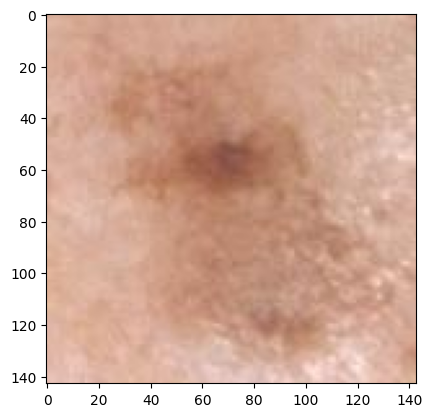

In [14]:
isic_id = df.isic_id.iloc[0]

# Image as Byte String
byte_string = training_validation_hdf5[isic_id][()]
print(f"Byte String: {byte_string[:20]}....")

# Convert byte string to numpy array
nparr = np.frombuffer(byte_string, np.uint8)

print("Image:")
image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)[...,::-1] # reverse last axis for bgr -> rgb
plt.imshow(image);

splitting

In [15]:
from sklearn.model_selection import StratifiedGroupKFold

df = df.reset_index(drop=True) # ensure continuous index
df["fold"] = -1
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=CFG.seed)
for i, (training_idx, validation_idx) in enumerate(sgkf.split(df, y=df.target, groups=df.patient_id)):
    df.loc[validation_idx, "fold"] = int(i)

# Use first fold for training and validation
training_df = df.query("fold!=0")
validation_df = df.query("fold==0")
print(f"# Num Train: {len(training_df)} | Num Valid: {len(validation_df)}")

# Num Train: 4706 | Num Valid: 1266


In [16]:
training_df.target.value_counts()

target
0    3088
1    1618
Name: count, dtype: int64

In [39]:
import pandas as pd

df2 = pd.DataFrame(training_df)

# Save the DataFrame to a CSV file
df2.to_csv('output.csv', index=False)

In [17]:
validation_df.target.value_counts()

target
0    919
1    347
Name: count, dtype: int64

# Features

In [18]:
# Categorical features which will be one hot encoded
CATEGORICAL_COLUMNS = ["sex", "anatom_site_general",
            "tbp_tile_type","tbp_lv_location", ]

# Numeraical features which will be normalized
NUMERIC_COLUMNS = ["age_approx", "tbp_lv_nevi_confidence", "clin_size_long_diam_mm",
           "tbp_lv_areaMM2", "tbp_lv_area_perim_ratio", "tbp_lv_color_std_mean",
           "tbp_lv_deltaLBnorm", "tbp_lv_minorAxisMM", ]

# Tabular feature columns
FEAT_COLS = CATEGORICAL_COLUMNS + NUMERIC_COLUMNS

In [19]:
def build_augmenter():
    # Define augmentations
    aug_layers = [
        keras_cv.layers.RandomCutout(height_factor=(0.02, 0.06), width_factor=(0.02, 0.06)),
        keras_cv.layers.RandomFlip(mode="horizontal"),
    ]
    
    # Apply augmentations to random samples
    aug_layers = [keras_cv.layers.RandomApply(x, rate=0.5) for x in aug_layers]
    
    # Build augmentation layer
    augmenter = keras_cv.layers.Augmenter(aug_layers)

    # Apply augmentations
    def augment(inp, label):
        images = inp["images"]
        aug_data = {"images": images}
        aug_data = augmenter(aug_data)
        inp["images"] = aug_data["images"]
        return inp, label
    return augment


def build_decoder(with_labels=True, target_size=CFG.image_size):
    def decode_image(inp):
        # Read jpeg image
        file_bytes = inp["images"]
        image = tf.io.decode_jpeg(file_bytes)
        
        # Resize
        image = tf.image.resize(image, size=target_size, method="area")
        
        # Rescale image
        image = tf.cast(image, tf.float32)
        image /= 255.0
        
        # Reshape
        image = tf.reshape(image, [*target_size, 3])
        
        inp["images"] = image
        return inp

    def decode_label(label, num_classes):
        label = tf.cast(label, tf.float32)
        label = tf.reshape(label, [num_classes])
        return label

    def decode_with_labels(inp, label=None):
        inp = decode_image(inp)
        label = decode_label(label, CFG.num_classes)
        return (inp, label)

    return decode_with_labels if with_labels else decode_image


def build_dataset(
    isic_ids,
    hdf5,
    features,
    labels=None,
    batch_size=32,
    decode_fn=None,
    augment_fn=None,
    augment=False,
    shuffle=1024,
    cache=True,
    drop_remainder=False,
):
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)

    if augment_fn is None:
        augment_fn = build_augmenter()

    AUTO = tf.data.experimental.AUTOTUNE

    images = [None]*len(isic_ids)
    for i, isic_id in enumerate(tqdm(isic_ids, desc="Loading Images ")):
        images[i] = hdf5[isic_id][()]
        
    inp = {"images": images, "features": features}
    slices = (inp, labels) if labels is not None else inp

    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.cache() if cache else ds
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    if shuffle:
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

In [20]:
## Train
print("# Training:")
training_features = dict(training_df[FEAT_COLS])
training_ids = training_df.isic_id.values
training_labels = training_df.target.values
training_ds = build_dataset(training_ids, training_validation_hdf5, training_features, 
                         training_labels, batch_size=CFG.batch_size,
                         shuffle=True, augment=True)

# Valid
print("# Validation:")
validation_features = dict(validation_df[FEAT_COLS])
validation_ids = validation_df.isic_id.values
validation_labels = validation_df.target.values
validation_ds = build_dataset(validation_ids, training_validation_hdf5, validation_features,
                         validation_labels, batch_size=CFG.batch_size,
                         shuffle=False, augment=False)


# Training:


Loading Images :   0%|          | 0/4706 [00:00<?, ?it/s]

# Validation:


Loading Images :   0%|          | 0/1266 [00:00<?, ?it/s]

KeyError: "Unable to synchronously open object (object 'ISIC_9005692' doesn't exist)"

In [21]:
feature_space = keras.utils.FeatureSpace(
    features={
        # Categorical features encoded as integers
        "sex": "string_categorical",
        "anatom_site_general": "string_categorical",
        "tbp_tile_type": "string_categorical",
        "tbp_lv_location": "string_categorical",
        # Numerical features to discretize
        "age_approx": "float_discretized",
        # Numerical features to normalize
        "tbp_lv_nevi_confidence": "float_normalized",
        "clin_size_long_diam_mm": "float_normalized",
        "tbp_lv_areaMM2": "float_normalized",
        "tbp_lv_area_perim_ratio": "float_normalized",
        "tbp_lv_color_std_mean": "float_normalized",
        "tbp_lv_deltaLBnorm": "float_normalized",
        "tbp_lv_minorAxisMM": "float_normalized",
    },
    output_mode="concat",
)

In [22]:
training_ds_with_no_labels = training_ds.map(lambda x, _: x["features"])
feature_space.adapt(training_ds_with_no_labels)

In [23]:
for x, _ in training_ds.take(1):
    preprocessed_x = feature_space(x["features"])
    print("preprocessed_x.shape:", preprocessed_x.shape)
    print("preprocessed_x.dtype:", preprocessed_x.dtype)

preprocessed_x.shape: (256, 71)
preprocessed_x.dtype: <dtype: 'float32'>


In [21]:
training_ds = training_ds.map(
    lambda x, y: ({"images": x["images"],
                   "features": feature_space(x["features"])}, y), num_parallel_calls=tf.data.AUTOTUNE)

validation_ds = validation_ds.map(
    lambda x, y: ({"images": x["images"],
                   "features": feature_space(x["features"])}, y), num_parallel_calls=tf.data.AUTOTUNE)

Output Shape of a Batch

In [22]:
batch = next(iter(validation_ds))

print("Images:",batch[0]["images"].shape)
print("Features:", batch[0]["features"].shape)
print("Targets:", batch[1].shape)

Images: (256, 128, 128, 3)
Features: (256, 71)
Targets: (256, 1)


# Validation

In [23]:
# AUC
auc = keras.metrics.AUC()

# Loss
loss = keras.losses.BinaryCrossentropy(label_smoothing=0.02)

# Modeling

In [24]:
# Define input layers
image_input = keras.Input(shape=(*CFG.image_size, 3), name="images")
feat_input = keras.Input(shape=(feature_space.get_encoded_features().shape[1],), name="features")
inp = {"images":image_input, "features":feat_input}

# Branch for image input
backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(CFG.preset)
x1 = backbone(image_input)
x1 = keras.layers.GlobalAveragePooling2D()(x1)
x1 = keras.layers.Dropout(0.2)(x1)

# Branch for tabular/feature input
x2 = keras.layers.Dense(96, activation="selu")(feat_input)
x2 = keras.layers.Dense(128, activation="selu")(x2)
x2 = keras.layers.Dropout(0.1)(x2)

# Concatenate both branches
concat = keras.layers.Concatenate()([x1, x2])

# Output layer
out = keras.layers.Dense(1, activation="sigmoid", dtype="float32")(concat)

# Build model
model = keras.models.Model(inp, out)

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=loss,
    metrics=[auc],
)

# Model Summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer) │ (None, 128, 128,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features            │ (None, 71)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficient_net_v2b2… │ (None, 4, 4,      │  8,769,374 │ images[0][0]      │
│ (EfficientNetV2Bac… │ 1408)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 96)        │      6,912 │ features[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1408)      │          0 │ efficient_net_v2… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     12,416 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1408)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1536)      │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      1,537 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,790,239 (33.53 MB)

 Trainable params: 8,707,951 (33.22 MB)

 Non-trainable params: 82,288 (321.44 KB)

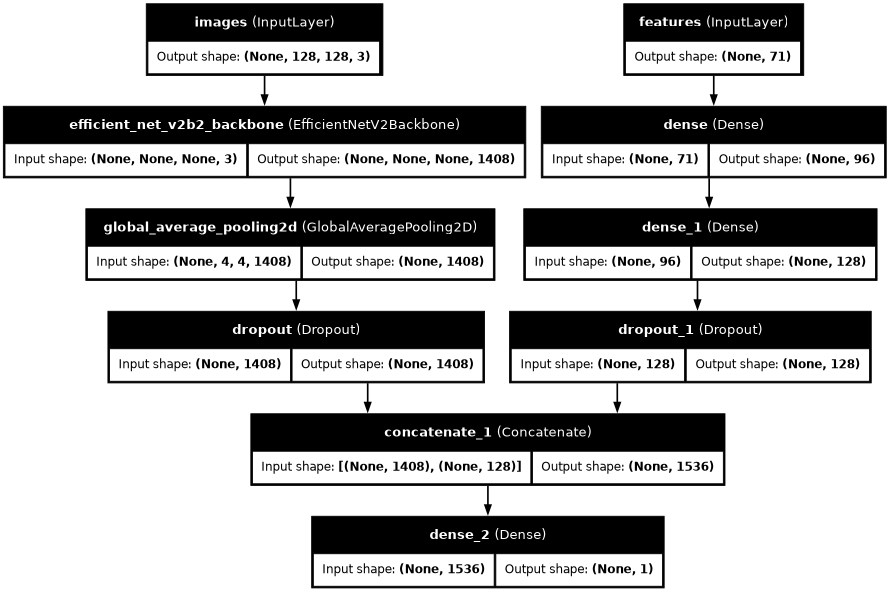

In [25]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, dpi=60)

# LR Schedule

In [26]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 2.5e-5, 5e-6 * batch_size, 0.8e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

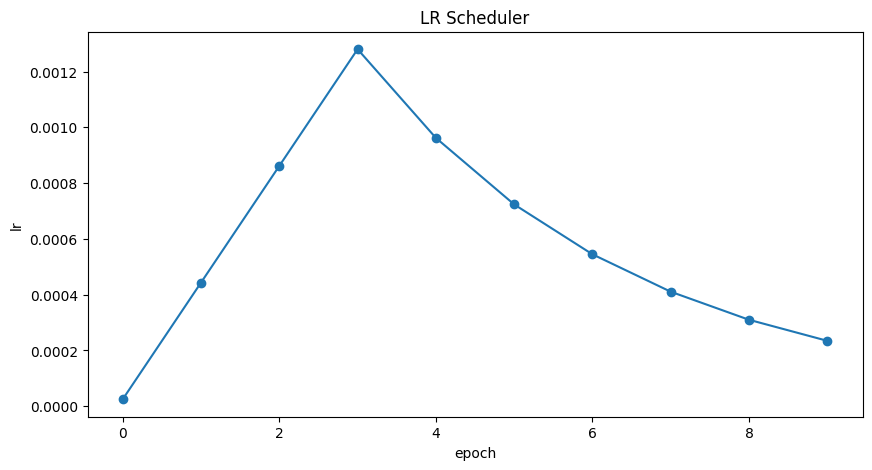

In [27]:
lr_cb = get_lr_callback(CFG.batch_size, mode="exp", plot=True)

# Model Checkpoint

In [28]:
ckpt_cb = keras.callbacks.ModelCheckpoint(
    "best_model.keras",   # Filepath where the model will be saved.
    monitor="val_auc",    # Metric to monitor (validation AUC in this case).
    save_best_only=True,  # Save only the model with the best performance.
    save_weights_only=False,  # Save the entire model (not just the weights).
    mode="max",           # The model with the maximum 'val_auc' will be saved.
)

In [29]:
history = model.fit(
    training_ds,
    epochs=CFG.epochs,
    callbacks=[lr_cb, ckpt_cb],
    validation_data=validation_ds,
    verbose=CFG.verbose,
    class_weight=class_weights,
)

Epoch 1/8


I0000 00:00:1733658968.245893      95 service.cc:145] XLA service 0x7de37c09e190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733658968.245984      95 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733659073.147956      95 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_11', 104 bytes spill stores, 132 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm3x_div_rn_noftz_f32_slowpath', 24 bytes spill stores, 24 bytes spill loads

I0000 00:00:1733659073.264789      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - auc: 0.4077 - loss: 0.7493

I0000 00:00:1733659169.610369      94 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_11', 104 bytes spill stores, 132 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm3x_div_rn_noftz_f32_slowpath', 24 bytes spill stores, 24 bytes spill loads



19/19 ━━━━━━━━━━━━━━━━━━━━ 265s 6s/step - auc: 0.4118 - loss: 0.7478 - val_auc: 0.3145 - val_loss: 0.8148 - learning_rate: 2.5000e-05
Epoch 2/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 496ms/step - auc: 0.7804 - loss: 0.5845 - val_auc: 0.7552 - val_loss: 0.5592 - learning_rate: 4.4333e-04
Epoch 3/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 499ms/step - auc: 0.9485 - loss: 0.3177 - val_auc: 0.7716 - val_loss: 0.5915 - learning_rate: 8.6167e-04
Epoch 4/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 495ms/step - auc: 0.9878 - loss: 0.1803 - val_auc: 0.8974 - val_loss: 0.4325 - learning_rate: 0.0013
Epoch 5/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 495ms/step - auc: 0.9963 - loss: 0.1213 - val_auc: 0.9325 - val_loss: 0.3952 - learning_rate: 9.6200e-04
Epoch 6/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 430ms/step - auc: 0.9991 - loss: 0.0918 - val_auc: 0.9079 - val_loss: 0.4748 - learning_rate: 7.2350e-04
Epoch 7/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 429ms/step - auc: 0.9995 - loss: 0.0861 - val_auc: 0.9243 - val_loss: 0.4674 - learning_rate: 5.4462e

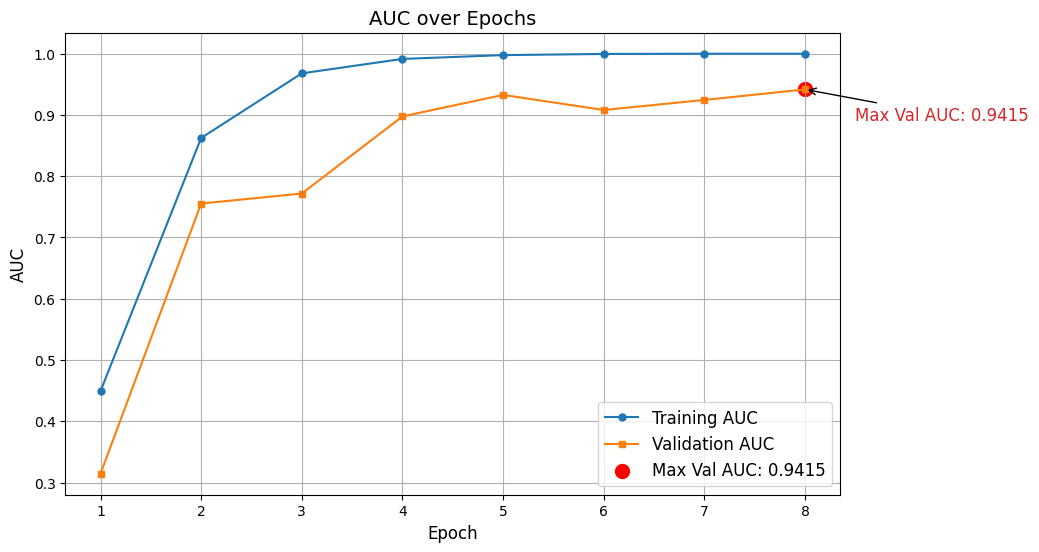

In [30]:
# Extract AUC and validation AUC from history
auc = history.history['auc']
val_auc = history.history['val_auc']
epochs = range(1, len(auc) + 1)

# Find the epoch with the maximum val_auc
max_val_auc_epoch = np.argmax(val_auc)
max_val_auc = val_auc[max_val_auc_epoch]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, auc, 'o-', label='Training AUC', markersize=5, color='tab:blue')
plt.plot(epochs, val_auc, 's-', label='Validation AUC', markersize=5, color='tab:orange')

# Highlight the max val_auc
plt.scatter(max_val_auc_epoch + 1, max_val_auc, color='red', s=100, label=f'Max Val AUC: {max_val_auc:.4f}')
plt.annotate(f'Max Val AUC: {max_val_auc:.4f}', 
             xy=(max_val_auc_epoch + 1, max_val_auc), 
             xytext=(max_val_auc_epoch + 1 + 0.5, max_val_auc - 0.05),
             arrowprops=dict(facecolor='black', arrowstyle="->"),
             fontsize=12,
             color='tab:red')

# Enhancing the plot
plt.title('AUC over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('AUC', fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)
plt.xticks(epochs)

# Show the plot
plt.show()

In [31]:
# Best Result
best_score = max(history.history['val_auc'])
best_epoch = np.argmax(history.history['val_auc']) + 1
print("#" * 10 + " Result " + "#" * 10)
print(f"Best AUC: {best_score:.5f}")
print(f"Best Epoch: {best_epoch}")
print("#" * 28)

########## Result ##########
Best AUC: 0.94148
Best Epoch: 8
############################


# Saving model

In [32]:
# Save the model in HDF5 format
model.save('my_model.h5')

print("Model has been saved as 'my_model.h5'")


Model has been saved as 'my_model.h5'


In [33]:
import tensorflow as tf

# Example feature dictionary
example_features = {
    'age_approx': 35,
    'sex': "male",
    'anatom_site_general': "lower extremity",
    'tbp_tile_type': "3D: XP",
    'tbp_lv_location': "Left Leg",
    'clin_size_long_diam_mm': 100.5,
    'tbp_lv_areaMM2': 40.3,
    'tbp_lv_area_perim_ratio': 1.75,
    'tbp_lv_color_std_mean': 7.1,
    'tbp_lv_deltaLBnorm': 00.12,
    'tbp_lv_minorAxisMM': 10.2,
    'tbp_lv_nevi_confidence': 0.2
}

# Convert the dictionary values to tf.Tensors
example_features_tensor = {key: tf.convert_to_tensor(value) for key, value in example_features.items()}

# Pass the features as a dictionary to the FeatureSpace
preprocessed_x = feature_space(example_features_tensor)

# Extract the values (it should contain the 71 transformed feature values)
preprocessed_values = preprocessed_x.numpy()

# Print the processed feature values (the 71 values)
print("Processed feature values (71 values):")
print(preprocessed_values)


Processed feature values (71 values):
[ 0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.         34.91565     0.          1.          0.
  1.4995145  -2.9856398   5.3847165  -2.289112    0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  3.8338432  -0.78568983  0.          1.          0.        ]


(1, 71)
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Prediction: Cancer (Probability: 0.94)


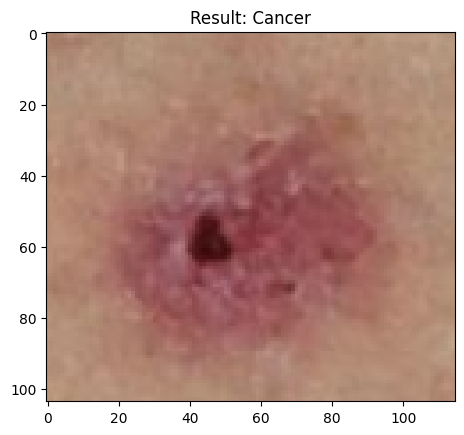

In [34]:
def load_and_preprocess_image(image_path, target_size):
    """
    Load and preprocess an image for prediction.
    :param image_path: Path to the local image.
    :param target_size: Target size for resizing the image.
    :return: Preprocessed image ready for prediction.
    """
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"The image at {image_path} could not be found.")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, tuple(target_size))
    image = image / 255.0  # Normalize pixel values
    return np.expand_dims(image, axis=0)  # Add batch dimension

def predict_image_with_features(image_path, model, target_size, features_input):
    """
    Predict if the image indicates cancer or not.
    :param image_path: Path to the local image.
    :param model: Trained model.
    :param target_size: Target size for resizing the image.
    :param features_input: Auxiliary input for the model (array of shape (1, 71)).
    :return: Prediction result.
    """
    # Preprocess the image
    preprocessed_image = load_and_preprocess_image(image_path, target_size)
    
    # Ensure features_input has the correct shape
    if features_input.shape != (1, 71):
        raise ValueError("features_input must have shape (1, 71).")
    
    # Predict using both inputs
    prediction = model.predict({'images': preprocessed_image, 'features': features_input})
    result = "Cancer" if prediction > 0.5 else "No Cancer"
    return result, prediction

# Path to the local image
local_image_path = "/kaggle/input/tryingmybest/rep.png"

# Dummy auxiliary features (replace with actual metadata if available)
features_input = np.array(preprocessed_values)
features_input = features_input.reshape(1, -1)

print(features_input.shape)

# Predict
try:
    result, probability = predict_image_with_features(local_image_path, model, CFG.image_size, features_input)
    print(f"Prediction: {result} (Probability: {probability[0][0]:.2f})")
    plt.imshow(cv2.cvtColor(cv2.imread(local_image_path), cv2.COLOR_BGR2RGB))
    plt.title(f"Result: {result}")
    plt.show()
except FileNotFoundError as e:
    print(e)
except ValueError as e:
    print(e)
